# Import needed modules

In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

print ('modules loaded')

modules loaded


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"omarmedhatmoheb","key":"cc095da20abceeb9426da9118d310b68"}'}

# **Data Preprocessing**

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


### **Read data and store it in dataframe**

In [4]:
!kaggle datasets list


ref                                                       title                                                size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  --------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
adilshamim8/social-media-addiction-vs-relationships       Students' Social Media Addiction                     7851  2025-05-10 14:38:02.713000           9327        133  1.0              
jayaantanaath/student-habits-vs-academic-performance      Student Habits vs Academic Performance              19512  2025-04-12 10:49:08.663000          36999        652  1.0              
orvile/stress-and-sleep-patterns                          Stress and Sleep Patterns                           18327  2025-05-25 08:26:17.490000           1514         22  0.88235295       
atharvasoundankar/ai-developer-productivity-dataset    

In [5]:
# Cell 1: Load Kaggle credentials from kaggle.json
import json
import os

kaggle_json_path = os.path.expanduser('~/.kaggle/kaggle.json')
with open(kaggle_json_path, 'r') as f:
    creds = json.load(f)

KAGGLE_USERNAME = creds['username']
KAGGLE_KEY      = creds['key']


In [6]:
# Cell 2: Install tqdm (progress bar) and requests
!pip install --quiet tqdm requests


In [7]:
# Cell 3: Download the dataset with a percentage progress bar
import requests
from tqdm import tqdm

# Build the download URL (ownerSlug/datasetSlug)
owner_slug   = 'imrankhan77'
dataset_slug = 'nct-crc-he-100k'
url = f'https://www.kaggle.com/api/v1/datasets/download/{owner_slug}/{dataset_slug}'

# Start a streaming GET request with HTTP Basic Auth
session = requests.Session()
session.auth = (KAGGLE_USERNAME, KAGGLE_KEY)
response = session.get(url, stream=True)

# If Kaggle asks for license confirmation, it returns a redirect to /download/license with a small payload.
# Passing the “?accept=true” query parameter forces acceptance of the license automatically:
if response.url.endswith('/license/download'):
    url_accept = url + '?accept=true'
    response = session.get(url_accept, stream=True)

# Read the total size from headers (in bytes)
total_size_in_bytes = int(response.headers.get('Content-Length', 0))
block_size = 1024  # 1 KB

zip_path = '/content/nct-crc-he-100k.zip'
with open(zip_path, 'wb') as file, tqdm(
    total=total_size_in_bytes // block_size,
    unit='KB',
    desc='Downloading NCT-CRC-HE-100K',
    ncols=80
) as prog:
    for chunk in response.iter_content(block_size):
        if chunk:
            file.write(chunk)
            prog.update(1)

print(f"✅ Download complete: {zip_path}")


✅ Download complete: /content/nct-crc-he-100k.zip


In [9]:
# Cell: Unzip with a visible progress bar using Python + tqdm

import zipfile
from tqdm import tqdm
import os

# Paths
zip_path     = '/content/nct-crc-he-100k.zip'
extract_path = '/content/nct-crc-he-100k'

# Ensure the target directory exists
os.makedirs(extract_path, exist_ok=True)

# Open the ZIP and list its members
with zipfile.ZipFile(zip_path, 'r') as z:
    members = z.namelist()

    # Use tqdm to show progress (percentage) as files are extracted
    for member in tqdm(members, desc='Unzipping NCT-CRC-HE-100K', unit='file'):
        z.extract(member, extract_path)


Unzipping NCT-CRC-HE-100K: 100%|██████████| 100000/100000 [03:20<00:00, 499.32file/s]


In [10]:
# 1. Import necessary libraries
import os
import pandas as pd

# 2. Specify the main data directory after extraction
data_dir = '/content/nct-crc-he-100k/NCT-CRC-HE-100K'

# 3. Create empty lists to store file paths and labels
filepaths = []
labels = []

# 4. List folder names inside data_dir (each folder represents a class/label)
folds = os.listdir(data_dir)

# 5. Iterate through each folder and collect file paths along with their labels
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    # Ensure that the item is indeed a directory
    if os.path.isdir(foldpath):
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            # Ensure the path points to a file (e.g., an image)
            if os.path.isfile(fpath):
                filepaths.append(fpath)
                labels.append(fold)

# 6. Create Pandas Series from the lists
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')

# 7. Concatenate them into a single DataFrame
df = pd.concat([Fseries, Lseries], axis=1)




In [11]:
df

,filepaths,labels
0,/content/nct-crc-he-100k/NCT-CRC-HE-100K/ADI/A...,ADI
1,/content/nct-crc-he-100k/NCT-CRC-HE-100K/ADI/A...,ADI
2,/content/nct-crc-he-100k/NCT-CRC-HE-100K/ADI/A...,ADI
3,/content/nct-crc-he-100k/NCT-CRC-HE-100K/ADI/A...,ADI
4,/content/nct-crc-he-100k/NCT-CRC-HE-100K/ADI/A...,ADI
...,...,...
99995,/content/nct-crc-he-100k/NCT-CRC-HE-100K/DEB/D...,DEB
99996,/content/nct-crc-he-100k/NCT-CRC-HE-100K/DEB/D...,DEB
99997,/content/nct-crc-he-100k/NCT-CRC-HE-100K/DEB/D...,DEB
99998,/content/nct-crc-he-100k/NCT-CRC-HE-100K/DEB/D...,DEB


### **Split data into train, valid, and test**

In [23]:
strat = df['labels']
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

# valid and test dataframe
strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

### **Create image data generator**

In [24]:
# crobed image size
batch_size = 128
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 80000 validated image filenames belonging to 9 classes.
Found 10000 validated image filenames belonging to 9 classes.
Found 10000 validated image filenames belonging to 9 classes.


### **Show sample from train data**

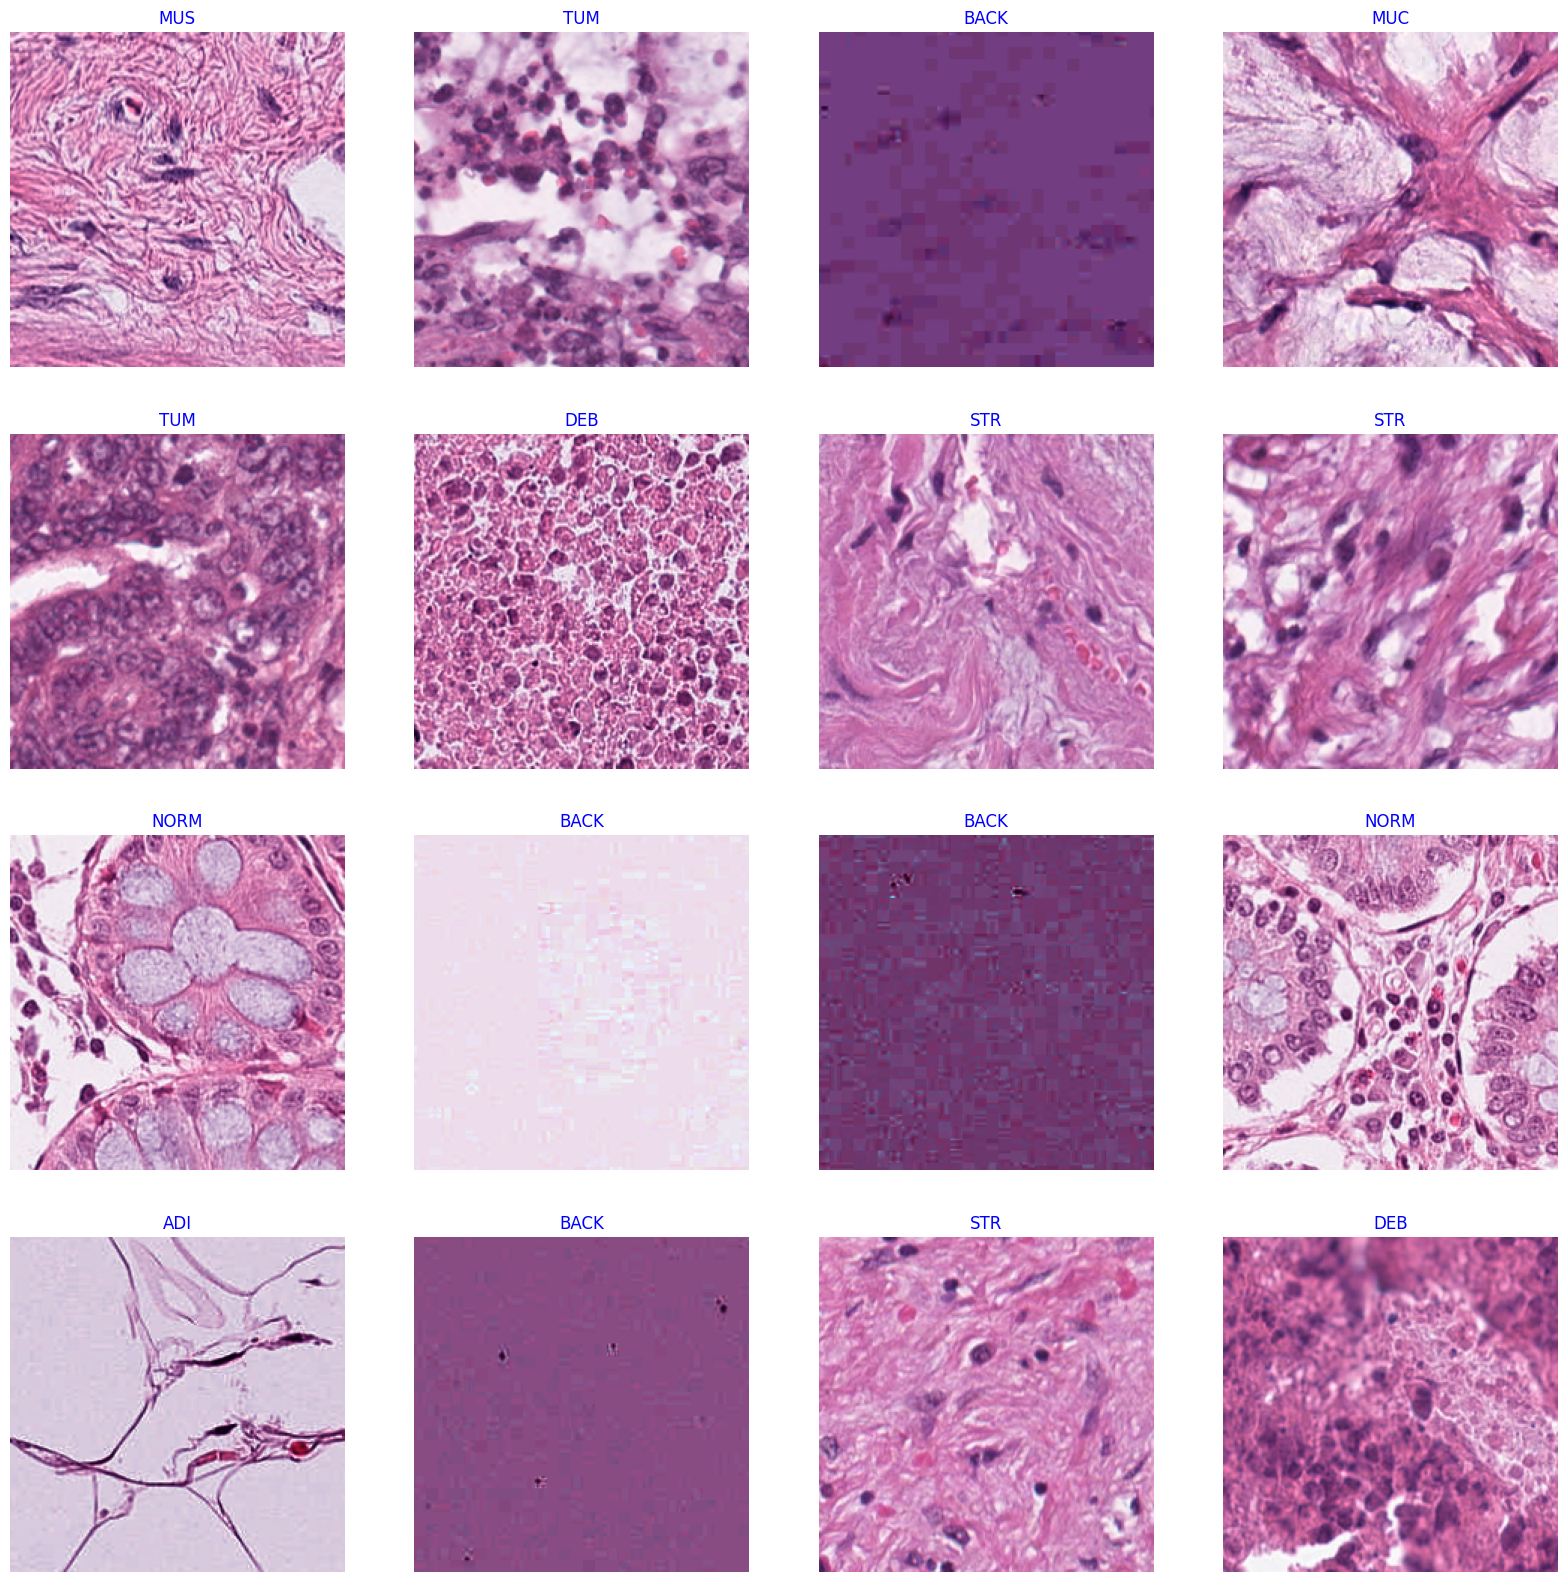

In [25]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# **Model Structure**

#### **Generic Model Creation**

In [29]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in output layer

base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet",
                                                               input_shape=img_shape, pooling='max')
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation= 'relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb5 (Functional)     │ (None, 2048)           │    28,513,527 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,048,576 (110.81 MB)

 Trainable params: 530,953 (2.03 MB)

 Non-trainable params: 28,517,623 (108.79 MB)

#### **Train model**

In [ ]:
history = model.fit(x=train_gen, epochs=10, verbose=1, validation_data=valid_gen)
loss_test, accuracy_test = model.evaluate(test_gen, verbose=1)
print(f'Test Loss: {loss_test:.4f}')
print(f'Test Accuracy: {accuracy_test:.4f}')

Epoch 1/10
418/625 ━━━━━━━━━━━━━━━━━━━━ 2:10 633ms/step - accuracy: 0.7331 - loss: 0.8534

#### **Display model performance**

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# **Evaluate model**

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

# **Get Predictions**

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

#### **Confusion Matrics and Classification Report**

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

#### **Save model**

In [ ]:
#Save the model
model.save('Model.h5')